In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/bitcoinprice_api.csv")

In [3]:
df.columns = ["date", "value"]

In [4]:
df["date"] = pd.to_datetime(df["date"], infer_datetime_format = True)
df.reset_index()
df = df.set_index(df["date"])
df = df.drop("date", axis=1, )
df

,value
date,
2018-01-01,13412.4400
2018-01-02,14740.7563
2018-01-03,15134.6513
2018-01-04,15155.2263
2018-01-05,16937.1738
...,...
2021-02-25,47104.7833
2021-02-26,46329.7400
2021-02-27,46189.3783


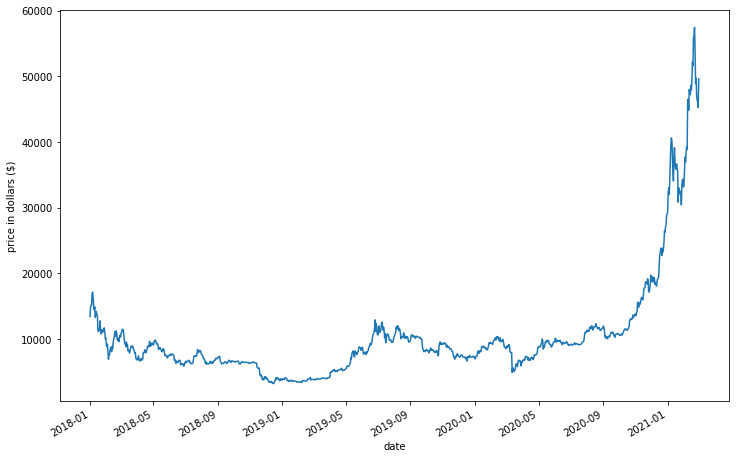

In [5]:
plt.figure(figsize=(12,8))
df["value"].plot()
plt.xlabel("date")
plt.ylabel("price in dollars ($)")
plt.show()

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_add = seasonal_decompose(df["value"], model="additive",period=7)
decomp_mult = seasonal_decompose(df["value"], model="multiplicative",period=7)

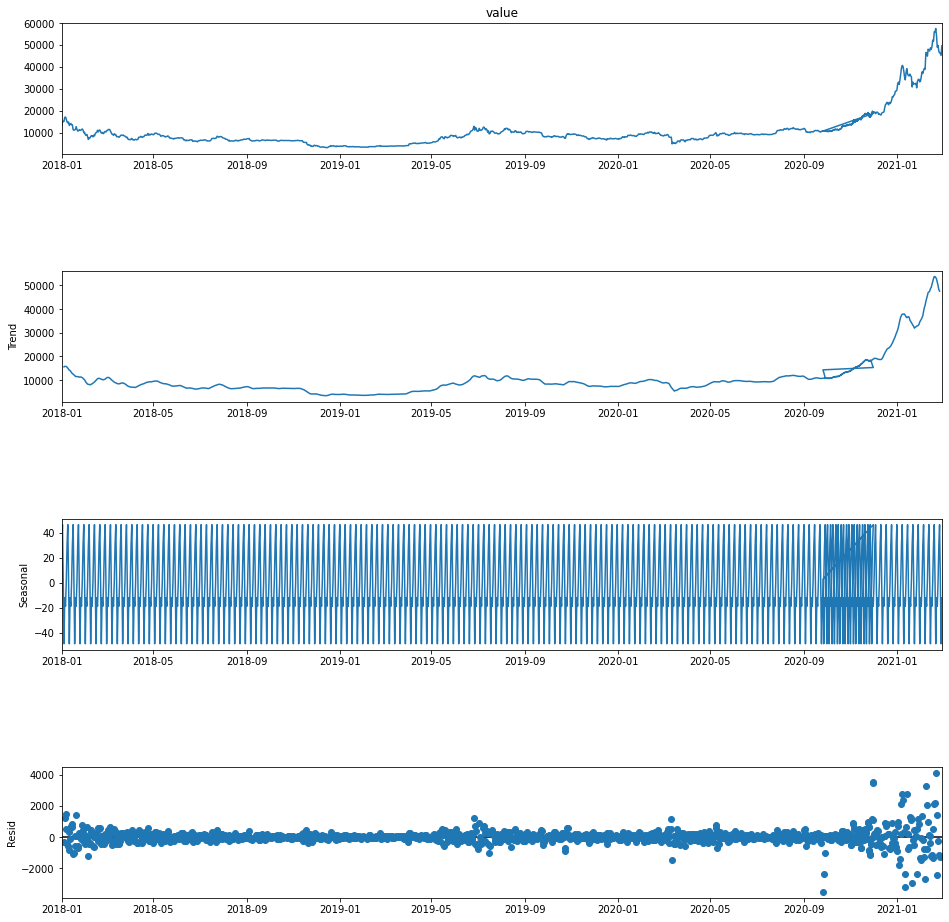

In [7]:
fig = decomp_add.plot();
fig.set_figheight(15)
fig.set_figwidth(15)

In [41]:
df_train = df[:'2020-09-04']
df_test = df['2020-09-05':]
print(df_train.shape)
print(df_test.shape)

(978, 1)
(245, 1)


In [42]:
y = df_train["value"]
from statsmodels.tsa.stattools import adfuller
adfuller(df_train["value"])[1]

0.03982267431198467

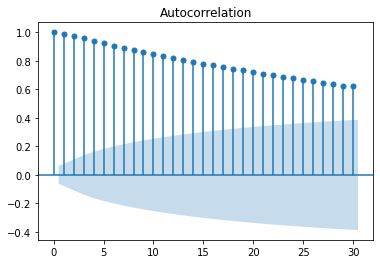

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y);

In [44]:
print('p-value: ', adfuller(y)[1])

p-value:  0.03982267431198467


p-value:  0.03982267431198467


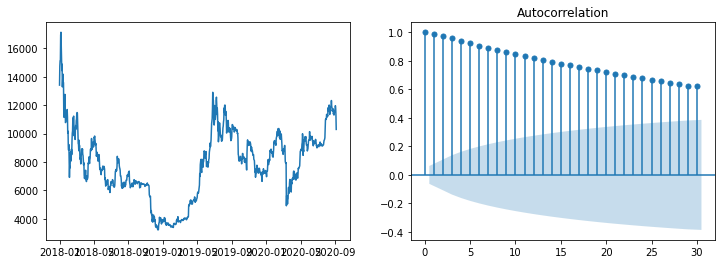

In [45]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(y)
plot_acf(y, ax=axes[1])
print('p-value: ', adfuller(y)[1])

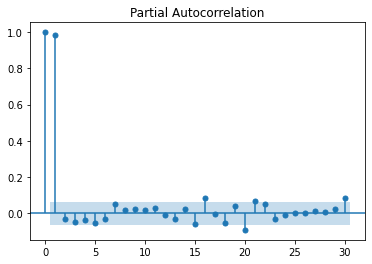

In [46]:
plot_pacf(y);

In [23]:
import pmdarima as pm

In [47]:
model = pm.auto_arima(y,
                      m=7, # frequency of series. Important to choose manually
                      seasonal=True,
                      stepwise=True,  # only check most interesting combination. False will take way longer.
                      start_p=0, max_p=2,
                      start_d=0, max_d=1,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_D=0, max_D=2,
                      start_Q=0, max_Q=2,
                      njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=14222.624, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=14225.244, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=14225.214, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=14220.706, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=14224.522, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=14224.535, Time=0.11 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=14225.764, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=14223.218, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=14223.287, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=14225.053, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.678 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  978
Model:               SARIMAX(0, 1, 0)   Log Likeliho

In [48]:
# Forecast
n_periods = len(df_test)
central, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = df_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

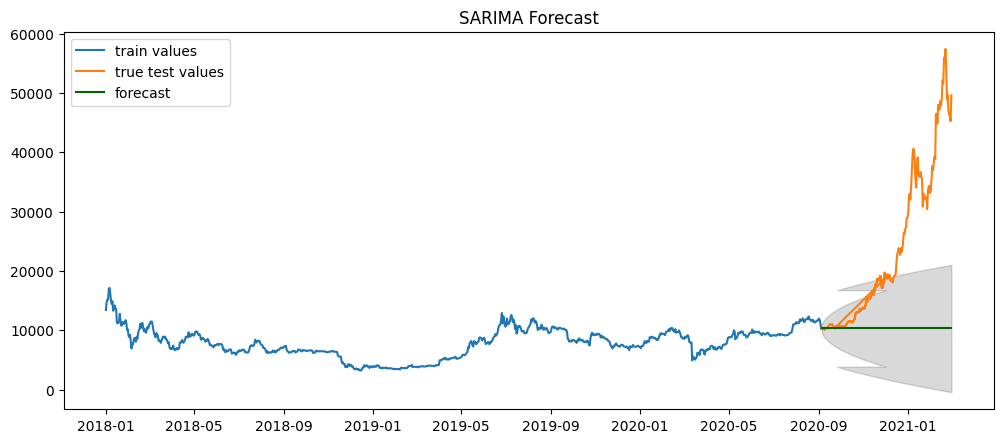

In [49]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()